Garrett Storey | Project 2 | DAT 301

    Background and Problem Definition

    Source Data Citation: 

        Valve Corporation, 2022
        https://store.steampowered.com/hwsurvey/videocard/

    I have always been fascinated by the Steam Hardware Surveys that are sent out to PC Gamers every month. They collect tons of information about the market trends of users. However, it is not readily available for download and is hard coded into the HTML on the Steam website. 
    
    They do some data visualization, but I was interested in some questions that they had not already answered. For instance, what are the most popular graphics cards? What is the market penetration like over time? Especially in light of the recent silicon shortage, these questions may reveal interesting answers.

    In this project, I use BeautifulSoup to parse the HTML and reconfigure the data, Pandas to organize the data into a data frame, and Matplotlib to create data visualizations that help us answer these questions.

In [61]:
#Import relevant libraries

from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import requests

In [62]:
#Use requests module to fetch HTML data, 
# and BeautifulSoup to parse the HTML into elements

GPU_ENDPOINT = 'https://store.steampowered.com/hwsurvey/videocard/'
response = requests.get(GPU_ENDPOINT)
soup = BeautifulSoup(response.content,'html.parser')

In [63]:
#Create a dataframe that mimics the Steam Hardware website. 
# First we get all GPU names in the "All Video Cards" section.

column_names = ["Name", "May", "Jun", "Jul", "Aug", "Sep"]
df = pd.DataFrame(columns=column_names)

all_gpu_div = soup.select(".substats_col_left.col_header")[1]

for item in all_gpu_div.next_elements:
    if item.name == "span" and "%" not in item.get_text():
        text = item.get_text()
        # df = df.append({"Name": text}, ignore_index=True)
        df = pd.concat([df, pd.DataFrame([{"Name": text}])], ignore_index=True)
    elif item.name == "div":
        if item.get_text() == "Other":
            break

display(df.head())

,Name,May,Jun,Jul,Aug,Sep
0,NVIDIA GeForce GTX 1060,NaN,NaN,NaN,NaN,NaN
1,NVIDIA GeForce GTX 1650,NaN,NaN,NaN,NaN,NaN
2,NVIDIA GeForce RTX 2060,NaN,NaN,NaN,NaN,NaN
3,NVIDIA GeForce GTX 1050 Ti,NaN,NaN,NaN,NaN,NaN
4,NVIDIA GeForce RTX 3060 Laptop GPU,NaN,NaN,NaN,NaN,NaN


In [64]:
#Here I create the main function used to iterate
# through the elements and add to the right columns. 
#The elements often had repeated class tags 
# which made using BeautifulSoup a bit difficult.
#The constants offset, stagger, begin, and shift 
# are used to skip unwanted span elements in the list.
#Since the september column had different element types than the others, 
# the function adapts and uses the correct constants for this situation.

def populate_col(elements, offset, month):
    if offset == 4:
        stagger = 1
        begin=1
        shift=1
    else:
        stagger = 4
        begin=offset
        shift=4
    for n in range(begin, len(df)*stagger+4, stagger):
        try:
            num = float(elements[n].get_text().removesuffix("%"))
        except:
            num = 0.00
        df[f"{month}"][int(((n-shift))/stagger)] = num
    

In [65]:
#Here I define the start of the section I want to analyze 
# by using the find_all_next method. 
# The end of the section is based on the list of names determined above. 
# Now the data frame has been cleaned up and prepared for visualization.
all_percentages = all_gpu_div.find_all_next(class_="substats_col_month")
last_month_percentages = all_gpu_div.find_all_next(class_="substats_col_month_last_pct")
for n in range(0,4):
    populate_col(all_percentages, n, column_names[n+1])
populate_col(last_month_percentages, 4, column_names[5])

display(df.head())

,Name,May,Jun,Jul,Aug,Sep
0,NVIDIA GeForce GTX 1060,7.17,7.02,7.12,6.6,6.94
1,NVIDIA GeForce GTX 1650,6.45,6.51,6.35,6.24,6.32
2,NVIDIA GeForce RTX 2060,5.08,5.03,5.1,5.02,5.19
3,NVIDIA GeForce GTX 1050 Ti,5.62,5.36,5.67,4.99,4.91
4,NVIDIA GeForce RTX 3060 Laptop GPU,2.68,2.99,3.34,3.39,4.0


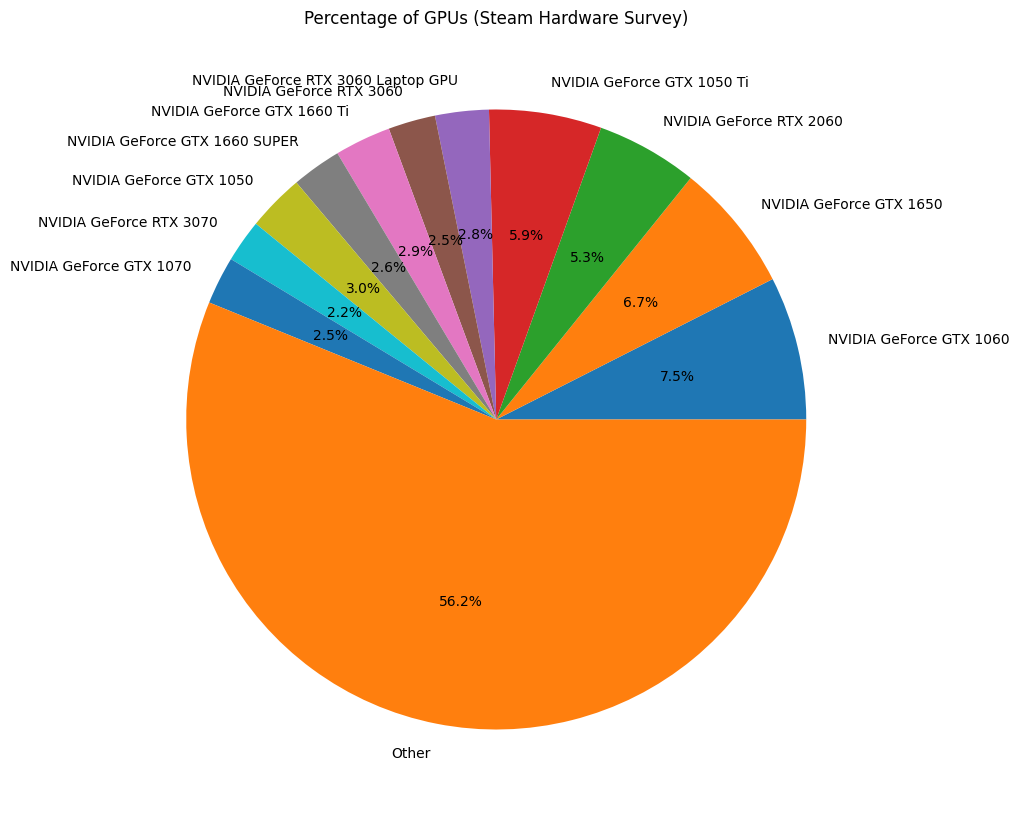

In [66]:
#I use matplotlib to create a pie chart of the most popular graphics cards. 
# I group any GPU used by less than 2% of users in the Other catagory. 

pie_df = df[df.May > 2]

pie_df = pd.concat(
    [pie_df, 
        pd.DataFrame( [ {
            "Name":"Other",
            "May": 100-sum(df[df.May<2].May)
        } ] )
    ], ignore_index=True)

fig1, ax1 = plt.subplots()
ax1.pie(pie_df.May, labels=pie_df.Name, autopct='%.1f%%')
ax1.set_title("Percentage of GPUs (Steam Hardware Survey)")
fig1.set_facecolor('white')
fig1.set_size_inches(10,12)
plt.show()

Here, we can see that NVIDIA obviously dominates the GPU space. Their 1000 series graphics cards like 1060s, 1650s, and the 1050 Ti clearly have been in circulation for a while considering that they are now about to sell their 4000 series cards. Competitors like AMD do not have the same market penetration in the GPU industry. 

Now that we know some of the most popular cards, I'd like to see how their use is changing over time. My hypothesis is that the use of old series cards are slowly dying out since they don't manufacture them anymore, and the newer cards like the 3070 or the 2060 are on the rise.

In [69]:
#Here I limit the data frame to the top 10 cards in use 
# in order to make a line plot of their users over time.

sorted_df = df.sort_values(by="May")
top_10_df = df[0:10]
display(top_10_df)

,Name,May,Jun,Jul,Aug,Sep
0,NVIDIA GeForce GTX 1060,7.17,7.02,7.12,6.6,6.94
1,NVIDIA GeForce GTX 1650,6.45,6.51,6.35,6.24,6.32
2,NVIDIA GeForce RTX 2060,5.08,5.03,5.1,5.02,5.19
3,NVIDIA GeForce GTX 1050 Ti,5.62,5.36,5.67,4.99,4.91
4,NVIDIA GeForce RTX 3060 Laptop GPU,2.68,2.99,3.34,3.39,4.0
5,NVIDIA GeForce RTX 3060,2.36,2.62,2.58,3.24,3.52
6,NVIDIA GeForce GTX 1660 Ti,2.81,2.66,2.79,2.55,2.57
7,NVIDIA GeForce GTX 1660 SUPER,2.48,2.42,2.47,2.46,2.52
8,NVIDIA GeForce GTX 1050,2.85,2.81,2.83,2.57,2.45
9,NVIDIA GeForce RTX 3070,2.13,2.02,2.29,2.32,2.33


Text(0.5, 1.0, 'Change in GPU of Steam Users in 2022')

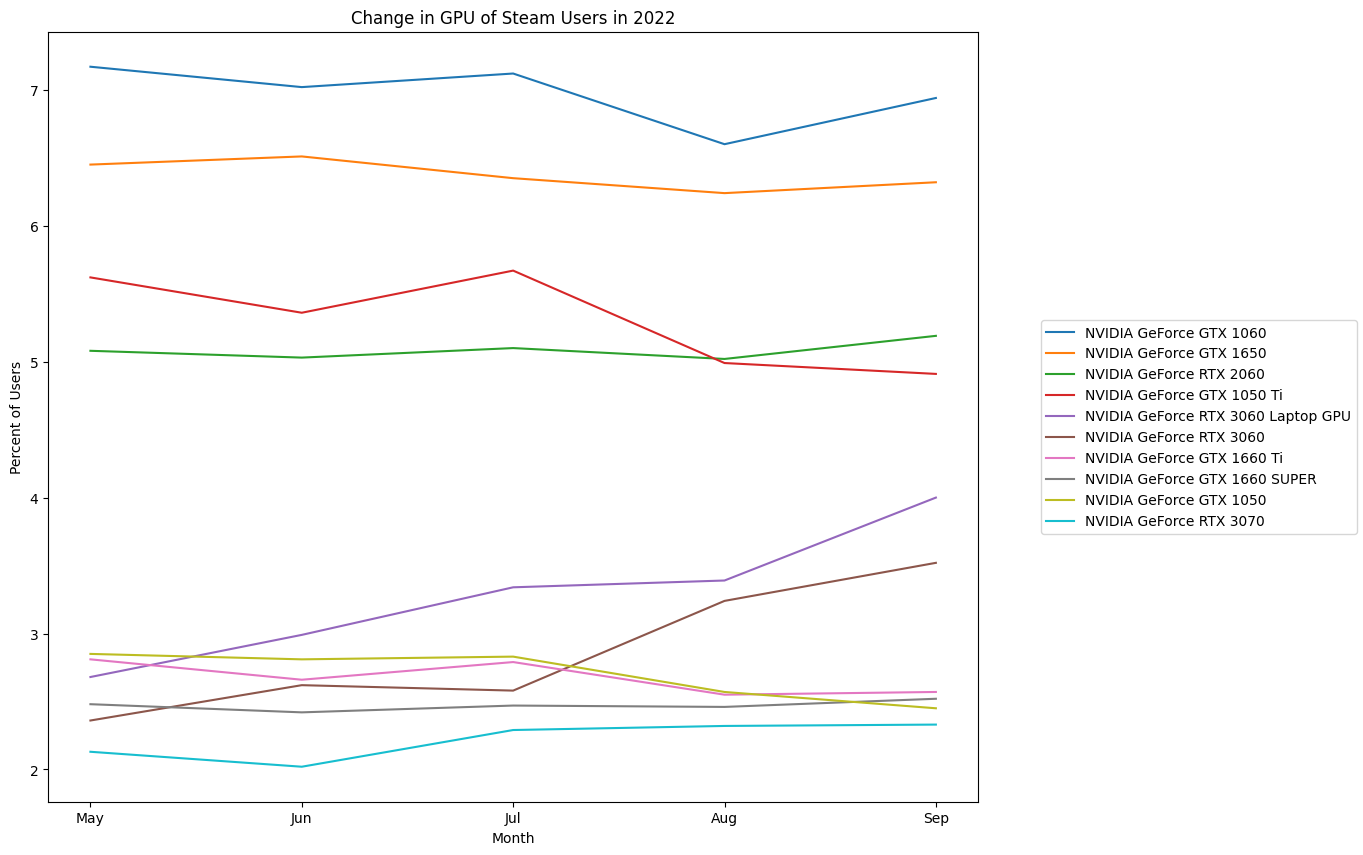

In [68]:
#I use matplotlib to make a lineplot of all ten GPUs over the five month period.

fig2, ax2 = plt.subplots()
fig2.set_size_inches(15,10)
for n in range(0,10):
    plt.plot(column_names[1:], top_10_df.iloc[n][1:6])
box=ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width*0.8, box.height])
fig2.legend(top_10_df.Name, loc='center right')
plt.xlabel('Month')
plt.ylabel('Percent of Users')
plt.title('Change in GPU of Steam Users in 2022')


Here we see some interesting trends. The old series 1000 cards actually seem to be fairly stable and begin to rise back up towards September. 

This is not what I would have anticipated. My hypothesis about newer cards like the 2060 and 3070/3060, however, do seem to be true with much more significant upwards growth. 

My interperetation of this data is that while some users are willing to spend money on a new card, much more users are willing to stick with the old, cheap, and reliable cards, which makes sense considering that the prices of new GPUs have been extremely high due to a silicon shortage.